## User Example

This notebook outlines the steps needed to use Syndat to generate a set of reduced experimental Transmission data for evaluating total neutron cross sections.

The primary user controls of interest are likely:
- energy grid structure
- total noise amount
- the spin groups to be considered
- the average parameter values for each of the spin groups


In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW

In [2]:
%matplotlib widget

### Define the particle-pair of interest

The particle pair class in syndat characterizes the reaction taking place. Pass is a list of spin groups and corresponding average parameters that you would like to consider for this particle pair. The format for both of these inputs is below. The method "map_quantum_numbers" will calculate (and print if print_out=True) the open reaction channels for given a maximum number of orbital angular momenta to consider. This can be used to visualize the spin groups that may be present in a cross section. 

In [3]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


## Instantiate an experiment

The Syndat *experiment* object holds significant information about the experiment at hand and has a number of methods that will generate raw count data from a theoretical cross section through a novel method developed by Walton, et al. Before 'running' the experiment (shown a few sections down) the object must be instantiated. This allows for an experimental setup to be defined once and 'ran' multiple times (shown with the MMDA module at the very end of this notebook).


A set of default experimental parameters is already loaded into the experiment class, however, if the user wants to re-define any this can be done by passing in a new_parameteres dictionary. The format for this is shown below. The example is that of the "trigs" parameter. This corresponds to the number of LINAC triggers the sample in data set was exposed to, which is proportional to the length of the measurement. Therefore, this parameter will control the noise level seen in the data.

The user has the option to input an open count spectra. This is an optional input and if None is given, Syndat will aproximate the open count rate spectra as an exponential. The calculate covaraince option, if set to false, will only calculate the diagonal of the covariance matrix.

To generate an energy grid that is similar to what would be seen in an experiment, you must start with time-of-flight. An experiment produces counts that are linearly spaced in time-of-flight which is related to energy by:

$ KE = \frac{1}{2}mv^2 = \frac{1}{2}m (\frac{FP}{ToF})^2 $ where FP is the distance or flight path and ToF is time of flight. The relativistic form of this equation can be used, however, it does not make m uch difference in this energy regime. 

* Note:
    Defining a linear energy grid will result in a wild binning stucture in tof. Consider defining a tof grid instead. In practice, the tof grid has a handful (5 or so) different bin widths and a constant bin width between each point of compresssion. This is due to the artisinal nature of this process, a complicated binning stucture is less justifiable, difficult to store in EXFOR, and requires the use of a complicated resolution broadening function.


In [4]:
# create an energy domain, min/max
E_min_max = [10, 200]
# E_min_max =[3.5, 2550]

### can calculate an energy grid yourself
# tof_min_max = syndat.exp_effects.e_to_t(np.array(E_min_max),35.185, True)
# # bin_width = 6.4e-9
# bin_width = 0.3e-6
# tof_grid = np.arange(min(tof_min_max), max(tof_min_max), bin_width)
# energy_grid = syndat.exp_effects.t_to_e(tof_grid,35.185,True)

### or just give the min/max and the experiment object will do the above
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

2440

### determine an appropriate energy window

In [5]:
# Erange_total = E_min_max
# maxres = 5
# probability = 0.01
# average_spacing = 8.4

# prob_comb = np.power(probability, (1/maxres))
# val = np.sqrt(2/np.pi) * np.sqrt(np.log(1/(1 - 2*prob_comb))) # (2*np.sqrt(np.log(1/(1 - prob_lessthan_comb))))/np.sqrt(np.pi)
# eV_spacing = val*average_spacing
# window_size = eV_spacing*maxres

# random_window_start = np.random.default_rng().uniform(min(Erange_total),max(Erange_total)-window_size,1)
# window_energy_domain = np.append(random_window_start, random_window_start+window_size)

# print(window_energy_domain)

# ladders = []
# for i in range(1000):
#     ladders.append(len(syndat.sample_levels.sample_RRR_levels(window_energy_domain, 8.4)))
#     # ladders.append(len(syndat.sample_levels.sample_resonance_levels(E0, N_levels, avg_level_spacing, method))
# ladders=np.array(ladders)
# np.count_nonzero(ladders[ladders>5])/1000
# max(ladders)

### Sample a ladder of resonances parameters using Syndat

In [6]:
spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })
                                    
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
# resonance_ladder = pd.DataFrame({'E':[1.94707086e+03,2.054739864e+03], 'Gg':[481.1, 536.2], 'gnx2':[113, 847], 'J':[3,3], 'chs':[1,1], 'lwave':[[0],[0]], 'J_ID':[None, None]})
resonance_ladder = pd.DataFrame({'E':[117], 'Gg':[46], 'gnx2':[60], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[None]})

# # look at your resonance ladder
# resonance_ladder['Gg'] = resonance_ladder['Gg']*10
resonance_ladder
# import json
# resonance_ladder.to_csv('test')
# test = pd.read_csv('test', index_col=0)
# # type(json.loads(test.lwave[0]))
# test = test.lwave.apply(json.loads)
# resonance_ladder['lwave']=test
# type(resonance_ladder.lwave[0])


,E,Gg,gnx2,J,chs,lwave,J_ID
0,117,46,60,3,1,0,None


### Calculate a theoretical cross section from the resonance ladder

The theoretical cross section can be calculated using the syndat code. The output total cross section must be converted to a transmission and stored in a dataframe with keys "E" and "theo_trans" before it can be passed to the experiment. The experiment object turns a theoretical cross section to a corresponding set of experimental Transmission data.

Transmission is related to total cross section in the following way:

$T = e^{-n*\sigma_t} $

Where n is the thickness of the target in unites atoms/barn.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.01, 'Energy (eV)')

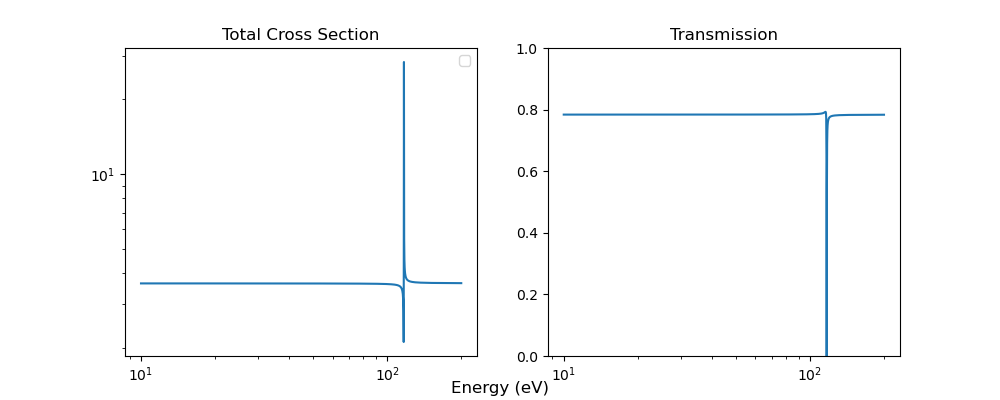

In [7]:
# SLWB with syndat
xs_tot, xs_scat, xs_cap = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
xs_tot2, xs_scat2, xs_cap2 = SLBW(exp.energy_domain, Ta_pair, pd.DataFrame())

# resonance_ladder2 = pd.DataFrame({'E':[117,130], 'Gg':[46,46], 'gnx2':[1,1], 'J':[3,3], 'chs':[1,1], 'lwave':[[0], [0]], 'J_ID':[1, 1]})
# xs_tot2, xs_scat2, xs_cap2 = syndat.scattering_theory.SLBW(exp.energy_domain, Ta_pair, resonance_ladder2)
# sammy = syndat.sammy_interface.calculate_xs(exp.energy_domain, resonance_ladder2, Ta_pair, 'SLBW', 'capture', 'no_exp', keep_runDIR=False)

# convert to transmisison and put in an appropriate dataframe
n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)
trans = np.exp(-n*xs_tot)
trans_thick = np.exp(-0.5*xs_tot)
trans2 = np.exp(-n*xs_tot2)
theoretical_df = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':trans})

fig, ax = subplots(1,2, figsize=(10,4))
# ax[0].plot(sammy_calculated.E, sammy_calculated.theo_xs, label='sammy')
ax[0].plot(exp.energy_domain, xs_scat)
# ax[0].plot(exp.energy_domain, xs_scat2)
# ax[0].plot(exp.energy_domain, xs_cap)
# ax[0].plot(exp.energy_domain, xs_cap)
# ax[0].plot(exp.energy_domain, xs_cap2)
# ax[0].plot(sammy.E, sammy.theo_xs, '.', label='sammy')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Total Cross Section')
ax[0].legend()

ax[1].plot(theoretical_df.E, theoretical_df.theo_trans)
# ax[1].plot(theoretical_df.E, trans2)
# ax[1].plot(theoretical_df.E, trans_thick)
# ax[1].plot(sammy_calculated.E, sammy_calculated.theo_trans, label='sammy')
ax[1].set_xscale('log')
ax[1].set_ylim([0,1])
ax[1].set_title('Transmission')

fig.supxlabel('Energy (eV)')

### Run the experiment & Analyze

The synthesized raw count data is then reduced to get an experimentally noisy data set with propagated uncertainty. That is stored in the "trans" attribute of the experiment object.

In [8]:
opendata = None #'/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/rpi-open-ta181.csv'
exp.run(theoretical_df, open_data = opendata)

In [9]:
# exp.Bi
exp.CovT

E,200.000000,199.431928,198.866273,198.303021,197.742159,197.183673,196.627549,196.073775,195.522337,194.973222,...,10.061690,10.055269,10.048854,10.042446,10.036043,10.029647,10.023257,10.016873,10.010495,10.004124
E,,,,,,,,,,,,,,,,,,,,,
200.000000,0.000641,0.000337,0.000338,0.000335,0.000341,0.000339,0.000316,0.000339,0.000340,0.000335,...,0.000375,0.000358,0.000370,0.000405,0.000373,0.000406,0.000348,0.000368,0.000326,0.000383
199.431928,0.000337,0.000688,0.000351,0.000348,0.000354,0.000352,0.000328,0.000352,0.000353,0.000347,...,0.000389,0.000371,0.000384,0.000421,0.000387,0.000421,0.000361,0.000382,0.000338,0.000398
198.866273,0.000338,0.000351,0.000695,0.000349,0.000355,0.000353,0.000329,0.000352,0.000354,0.000348,...,0.000390,0.000372,0.000385,0.000422,0.000388,0.000422,0.000362,0.000383,0.000339,0.000399
198.303021,0.000335,0.000348,0.000349,0.000681,0.000351,0.000350,0.000326,0.000349,0.000350,0.000345,...,0.000386,0.000369,0.000381,0.000418,0.000385,0.000418,0.000359,0.000380,0.000336,0.000396
197.742159,0.000341,0.000354,0.000355,0.000351,0.000697,0.000355,0.000331,0.000355,0.000356,0.000351,...,0.000393,0.000375,0.000388,0.000425,0.000391,0.000425,0.000365,0.000386,0.000342,0.000402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.029647,0.000406,0.000421,0.000422,0.000418,0.000425,0.000423,0.000394,0.000423,0.000424,0.000418,...,0.000478,0.000456,0.000471,0.000517,0.000474,0.003605,0.000443,0.000469,0.000414,0.000489
10.023257,0.000348,0.000361,0.000362,0.000359,0.000365,0.000363,0.000338,0.000363,0.000364,0.000358,...,0.000411,0.000392,0.000405,0.000444,0.000407,0.000443,0.002988,0.000403,0.000356,0.000420
10.016873,0.000368,0.000382,0.000383,0.000380,0.000386,0.000384,0.000358,0.000383,0.000385,0.000379,...,0.000434,0.000414,0.000428,0.000469,0.000430,0.000469,0.000403,0.003172,0.000376,0.000444


In [10]:
# figure()
# errorbar(exp.odat.E, exp.odat.cps, yerr=exp.odat.dcps, 
#                                                 fmt='.', color='b', linewidth=1, markersize=3, capsize=2, label='exp_o')
# plot(exp.odat.E, exp.redpar.val.ko*exp.Bi+exp.redpar.val.b0o, label='bkg_o')

# errorbar(exp.sdat.E, exp.sdat.cps, yerr=exp.sdat.dcps, 
#                                                 fmt='.', color='orange', linewidth=1, markersize=3, capsize=2, label='exp_s')
# plot(exp.sdat.E, exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s, label='bkg_s')              

# legend()
# xscale('log'); xlabel('Energy (eV)')
# yscale('log'); ylabel('cps')

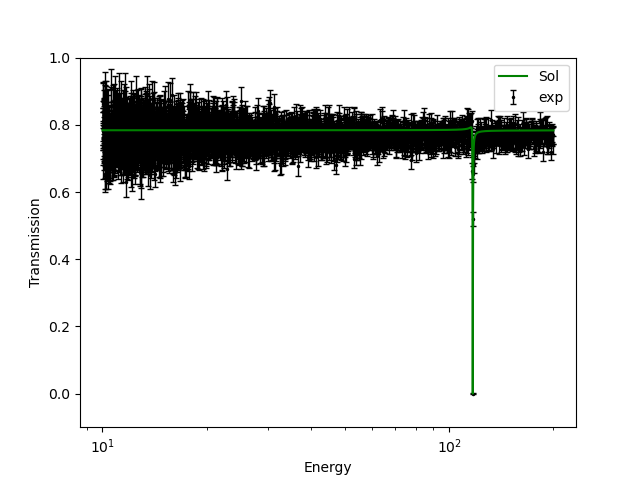

In [11]:
figure()
# plot(exp.trans.E, exp.trans.exp_trans, '.', ms=1, label='exp')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=np.sqrt(np.diag(exp.CovT)), zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

plot(exp.theo.E, exp.theo.theo_trans, '-', ms=1, color='g', label='Sol', zorder=2)

ylim([-.1, 1])
xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

### Output in SAMMY format

The data in the experiment object can be accessed directly, or Syndat has a set of utilities to write (and read) SAMMY formatted data files.

In this example, the sammy.dat file will contain the experimental data while the sammy.par file will contain the theoretical parameters from which the data was generated.

In [12]:
# syndat.write_samdat(exp.trans,"./test_sammy.dat")
# syndat.sammy_interface.write_sampar(resonance_ladder, Ta_pair, False, "./test_sammy.par") #, template="/Users/noahwalton/Documents/GitHub/nuc_syndat/templates/sammy_template_RM_only.par")

## Generating many sets of data

The Module for Mass Data Acquisition (MMDA) can be used to conveniently generate multiple different sets of data. An example is shown below. The case_directory will house data from each sample in a systematic/organized way.

Note: the particle pair object you pass to MMDA must have sp[in groups and average parameters defined upon instantiation

In [13]:


# case_file = './MMDA_data'  # if NOT using hdf5
# case_file = './MMDA_data.hdf5'  # if using hdf5
case_file = '/Users/noahwalton/Documents/GitHub/ATARI/Fitting/fitting_lite/syndat_data_SLBW.hdf5'

dataset_range = (0, 10)

spin_groups = [ (3.0,1,0) ]
# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )    

# vary_Erange = {'fullrange':(3,1000), 'maxres':5 , 'prob':0.01}
vary_Erange = None

samples_not_generated = generate(Ta_pair, exp, 
                                        'syndat_SLBW', 
                                        dataset_range, 
                                        case_file,
                                        fixed_resonance_ladder=None, 
                                        open_data=None,
                                        vary_Erange=vary_Erange,
                                        use_hdf5=True,
                                        overwrite = True
                                                                    )

# vary_Erange.keys()

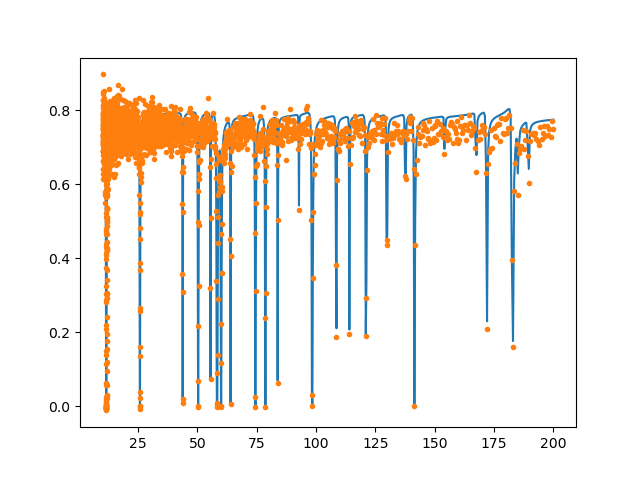

In [14]:
import ATARI.atari_io.hdf5 as io
exp_pw, exp_cov = io.read_experimental(case_file, 2)
# test = pd.read_hdf(case_file, 'sample_2/exp_pw')
figure()
plot(exp_pw.E, exp_pw.theo_trans)
plot(exp_pw.E, exp_pw.exp_trans, '.')